In [ ]:
#Technical Analysis Systems (Apostolos Dasilas)
#Taouktsis Xenofon (dai19312)
#Υπολογισμοί Price Momentum Oscillator (PMO)
#Δεδομένα από το [investing.com]
#Τα δεδομένα (.csv) όπως τα κατεβάζουμε απευθείας από το investing.com
#Το αρχείο θα έχει όνομα συμβόλου και μετατροπή από π.χ. ETH.csv σε ETH_md.csv
#UPDATE 071220 - v7

**Εισαγωγή Functions**

In [ ]:
#Βήμα 1 | Libraries Input
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

#Global
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
#Βήμα 2 | Upload Dataset Function
def upload_dataset():
    data_upload = files.upload()
    filename = list(data_upload.keys())[0]
    filename = re.sub(".csv", "", filename)
    return filename

In [ ]:
#Βήμα 3 | Simple SMA with Plot Function
def sma_info(dataset, window_value, plot_values):
  tmp_sma = pd.DataFrame()
  tmp_sma['Price'] = dataset['Price'].rolling(window=window_value).mean()
  tmp_sma.columns = ['Price'+'_SMA'+ str(window_value)]
  if plot_values == True:
      plt.plot(tmp_sma)
      plt.plot(dataset['Price'])
      plt.show()
  return tmp_sma

In [ ]:
#Βήμα 4 | Price Momentum Oscillator (PMO) calculation Formula
def pmo_calculation(dataset,window_value_A,window_value_B):
    plot_values = False
    drop_columns = ['Open', 'High', 'Low', 'Volume']
    dset = dataset.drop(columns = drop_columns)
    SMA_A = sma_info(dataset,window_value_A,plot_values)
    SMA_B = sma_info(dataset,window_value_B,plot_values)
    PMO = pd.DataFrame(SMA_A.iloc[:,0] - SMA_B.iloc[:,0])
    PMO.columns = ['T'+str(window_value_A)+"-"+str(window_value_B)]
    result_values = pd.DataFrame()
    result_values = pd.concat([dset, SMA_A, SMA_B, PMO], axis=1)
    return result_values

In [ ]:
#Βήμα 5 | PMO - Signal to Buy or to Sell Report Function
def pmo_signal_buy_sell_report(data_input):
    ###
    check_signal = []
    range_a = data_input.isna().sum()[4]
    for i in range(range_a):
        check_signal.append(np.nan)

    c = range_a-1
    range_b = len(data_input)-1
    for i in range(c,range_b):
        if data_input.iloc[:,4][i+1] < 0:
            check_signal.append(-1)
        else:
            check_signal.append(1)

    check_signal = pd.DataFrame(check_signal)
    check_signal.columns = ['flag']
    ###

    ###
    signals = []
    range_c = check_signal.isna().sum()[0]+1
    for i in range(range_c):
        signals.append(np.nan)

    range_value = len(check_signal)
    i=range_c
    while i < (range_value):
        tmp_value = check_signal['flag'][i-1]
        tmp_next_value = check_signal['flag'][i]
        if tmp_next_value == tmp_value:
            signals.append(np.nan)
        else:
            signals.append(tmp_next_value)
        i = i + 1
    signals = pd.DataFrame(signals)
    signals.columns = ["Buy_Sell_Flag"]
    ###

    ###
    drop_columns = [2,3,4] #['Price_SMA10', 'Price_SMA20', 'T10-20']
    tmp_dataset = data_input.drop(data_input.columns[drop_columns],axis=1)
    signal_prices = pd.DataFrame()
    signal_prices = pd.concat([tmp_dataset,signals], axis=1)
    ###

    ###
    DATA_A = pd.DataFrame(signal_prices.iloc[:,1]) #Price (close values)
    DATA_B = pd.DataFrame(signal_prices.iloc[:,2]) #Flag Buy or Sell (PMO)
    length_dataset = len(signal_prices)

    signal_buy = []
    signal_sell = []
    flag_id = 0
    for i in range(length_dataset):
        if DATA_B.iloc[:,0][i] == 1:
            if flag_id != 2:
                signal_buy.append(DATA_A['Price'][i])
                signal_sell.append(np.nan)
                flag_id = 2
            else:
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        elif  DATA_B.iloc[:,0][i] == -1:
            if flag_id !=1:
                signal_buy.append(np.nan)
                signal_sell.append(DATA_A['Price'][i])
                flag_id = 1
            else:
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        else:
            signal_buy.append(np.nan)
            signal_sell.append(np.nan)
    ###

    ###
    report_buy_sell = pd.DataFrame()
    report_buy_sell['Date'] = dataset.iloc[:,0]
    report_buy_sell['signal_buy_price'] = signal_buy
    report_buy_sell['signal_sell_price'] = signal_sell
    ###

    ###
    dates_to_buy = report_buy_sell.loc[report_buy_sell['signal_buy_price']>0]
    dates_to_buy = dates_to_buy.drop(dates_to_buy.columns[2],axis=1)
    dates_to_sell = report_buy_sell.loc[report_buy_sell['signal_sell_price']>0]
    dates_to_sell = dates_to_sell.drop(dates_to_sell.columns[1],axis=1)
    ###

    ###
    dates_buy_sell = pd.concat([dates_to_buy, dates_to_sell])
    dates_buy_sell.sort_index(inplace=True)
    dates_buy_sell.set_index('Date', inplace = True)
    ###

    return (report_buy_sell, dates_buy_sell)

In [ ]:
#Βήμα 6 | Plot Total Signal Report (PMO)
def pmo_plot_total_signals(metric_results,total_dates_report):
    #import datetime
    #plt.style.use('default')
    #plt.style.use('fivethirtyeight')

    symbol_name = re.sub("_md", "", filename)

    sma_a_name = metric_results.columns[2]
    sma_b_name = metric_results.columns[3]
    sma_a_label = re.sub("Price_", "", sma_a_name)
    sma_b_label = re.sub("Price_", "",  sma_b_name)

    fig1, ax1 = plt.subplots(figsize=(13, 5))
    metric_results = metric_results.set_index(pd.DatetimeIndex(metric_results['Date'].values))

    plt.plot(metric_results['Price'], label = symbol_name, alpha = 0.80, color = 'violet')
    plt.plot(metric_results[sma_a_name], label = sma_a_label, alpha = 0.80,  color = 'red')
    plt.plot(metric_results[sma_b_name], label = sma_b_label, alpha = 0.80,  color = 'green')

    total_dates_report = total_dates_report.set_index(pd.DatetimeIndex(metric_results['Date'].values))

    #Check Null Signals
    if len(total_dates_report) != total_dates_report.isnull().sum().sum()/2 :
        plt.scatter(total_dates_report.index, total_dates_report['signal_buy_price'],label = 'Buy',marker = '^', color = 'forestgreen')
        plt.scatter(total_dates_report.index, total_dates_report['signal_sell_price'], label = 'Sell', marker = 'v', color = 'black')

    plt.title('Buy and Sell Signals | Symbol: ' + symbol_name + ' [Price History]')
    plt.ylabel('Price USD')
    plt.legend(loc=2, prop={'size': 7})
    #ax1.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
    #ax1.set_xlim([datetime.date(2019, 10, 31), datetime.date(2020, 11, 5)])
    ax1.set_xlim([total_dates_report.index[0], total_dates_report.index[len(total_dates_report)-1]])
    plt.tight_layout()
    plt.show()

    #PMO PLOT
    fig2, ax2 = plt.subplots(figsize=(13, 5))
    pmo_name = metric_results.columns[4]
    plt.plot(metric_results[pmo_name], label = symbol_name, alpha = 0.80, color = 'red')
    plt.axhline(0, linestyle='dotted', color = 'red')
    #plt.title(pmo_name+' PLOT')
    plt.ylabel(pmo_name +' PMO values')
    #ax2.set_xlim([datetime.date(2019, 10, 31), datetime.date(2020, 11, 5)])
    ax2.set_xlim([total_dates_report.index[0], total_dates_report.index[len(total_dates_report)-1]])
    plt.tight_layout()
    plt.show()
    return

**Απευθείας CSV to CSV_md - INVESTING.COM**

In [ ]:
#Βήμα SOS
#Direct CSV to CSV_md (investing.com)
def md_csv_dataset(filename):
    chart = pd.read_csv(filename+".csv",
                        sep = ',')
    n_col = len(chart.columns)
    chart = chart.drop(chart.columns[n_col-1],axis=1)

    if len(chart.columns) < 6 :
        chart['Volume'] = 0
        id = 1
    else :
        id = 0

    chart.columns = ['Date','Price',
                    'Open','High',
                    'Low','Volume']

    #Μορφή Ημερομηνίας
    chart.Date = pd.to_datetime(chart.Date).dt.strftime('%m-%d-%Y')

    chart = chart.replace(',','', regex=True)
    chart = chart.replace('%','', regex=True)
    chart.iloc[:,1:6] = chart.iloc[:,1:6].replace('-','0', regex=True)

    chart['Date'] = chart['Date'].astype(np.datetime64)
    chart['Date'] = chart['Date'].dt.date
    chart['Price'] = chart['Price'].astype(np.float64)
    chart['Open'] = chart['Open'].astype(np.float64)
    chart['High'] = chart['High'].astype(np.float64)
    chart['Low'] = chart['Low'].astype(np.float64)

    if id!=1:
        for i in range(len(chart)):
            tmp_value = chart.iloc[i,5]
            if tmp_value != re.sub("K", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("K", "",tmp_value)) * 1000
            elif tmp_value != re.sub("M", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("M", "",tmp_value)) * 1000000
            elif  tmp_value != re.sub("B", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("B", "",tmp_value)) * 1000000000
        chart['Volume'] = chart['Volume'].astype(np.float64)
    else:
        #update 111220
        chart['Volume'] = 0 #Υπήρχε θέμα με το volume οπότε το θέτω με μηδέν ( 0 ) όταν δεν υπάρχει η στήλη από το investing.com
        #md_col = len(chart.columns)
        #chart = chart.drop(chart.columns[md_col-1],axis=1)

    chart.sort_values(by=['Date'], inplace=True, ascending=True)

    #update 081220
    chart.index = range(len(chart['Date']))

    return chart

**Αρχή Διαδικασιών PMO**

In [ ]:
#Βήμα 1 | Upload .csv Dataset (.csv)
filename = upload_dataset()
filename
#Το αποτέλεσμα θα είναι π.χ. filename = "AAPL"

Saving INTC Ιστορικά Δεδομένα.csv to INTC Ιστορικά Δεδομένα (1).csv


'INTC Ιστορικά Δεδομένα (1)'

In [ ]:
#Βήμα 2 | Creation of Dataset (load .csv file)
#Επιλογές Υποδιαστολής
#American xlsx επιλογή decimal_select = '.' εάν το csv έχει αποθηκευτεί με ( . )
#European xlsx επιλογή decimal_select = ',' εάν το csv έχει αποθηκευτεί με ( , )

#Επιλογή Διαχωρισμού Στηλών
#European xlsx sep_select = ';' εάν το csv έχει αποθηκευτεί με ( ; )
#American xlsx sep_select = ',' εάν το csv έχει αποθηκευτεί με ( , )

#decimal_select = ',' #Υποδιαστολή
#sep_select = ';' #Διαχωρισμός Στηλών

dataset = md_csv_dataset(filename)
dataset

<ipython-input-18-052c46b199ca>:20: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  chart.Date = pd.to_datetime(chart.Date).dt.strftime('%m-%d-%Y')


Date   Price    Open    High     Low        Volume
0    2022-01-11  2830.0  2880.0  2885.0  2789.0  4.442000e+09
1    2022-01-12  2983.0  3024.0  3048.0  2952.0  3.890000e+09
2    2022-02-11  2742.0  2827.0  2885.0  2741.0  5.196000e+09
3    2022-02-12  2941.0  2917.0  2943.0  2871.0  3.155000e+09
4    2022-03-11  2739.0  2745.0  2788.0  2717.0  3.968000e+09
..          ...     ...     ...     ...     ...           ...
248  2023-12-05  2895.0  2902.0  2910.0  2872.0  2.415000e+09
249  2023-12-06  3307.0  3140.0  3330.0  3136.0  5.967000e+09
250  2023-12-07  3398.0  3369.0  3408.0  3306.0  3.728000e+09
251  2023-12-09  3886.0  3865.0  4007.0  3865.0  5.465000e+09
252  2023-12-10  3684.0  3680.0  3722.0  3639.0  2.356000e+09

[253 rows x 6 columns]

In [ ]:
#Βήμα 3 | PMO T10-20 Results Analysis
window_value_A = 10
window_value_B = 20
pmo_results = pmo_calculation(dataset,window_value_A,window_value_B)
pmo_results

Date   Price  Price_SMA10  Price_SMA20  T10-20
0    2022-01-11  2830.0          NaN          NaN     NaN
1    2022-01-12  2983.0          NaN          NaN     NaN
2    2022-02-11  2742.0          NaN          NaN     NaN
3    2022-02-12  2941.0          NaN          NaN     NaN
4    2022-03-11  2739.0          NaN          NaN     NaN
..          ...     ...          ...          ...     ...
248  2023-12-05  2895.0       3259.8      3361.10 -101.30
249  2023-12-06  3307.0       3292.0      3363.85  -71.85
250  2023-12-07  3398.0       3308.3      3383.90  -75.60
251  2023-12-09  3886.0       3408.3      3414.50   -6.20
252  2023-12-10  3684.0       3443.7      3425.30   18.40

[253 rows x 5 columns]

In [ ]:
#Βήμα 4 | PMO First 30 results
pmo_results.head(n=30)

Date   Price  Price_SMA10  Price_SMA20  T10-20
0   2022-01-11  2830.0          NaN          NaN     NaN
1   2022-01-12  2983.0          NaN          NaN     NaN
2   2022-02-11  2742.0          NaN          NaN     NaN
3   2022-02-12  2941.0          NaN          NaN     NaN
4   2022-03-11  2739.0          NaN          NaN     NaN
5   2022-04-11  2820.0          NaN          NaN     NaN
6   2022-05-12  2917.0          NaN          NaN     NaN
7   2022-06-12  2860.0          NaN          NaN     NaN
8   2022-07-11  2841.0          NaN          NaN     NaN
9   2022-07-12  2833.0       2850.6          NaN     NaN
10  2022-08-11  2848.0       2852.4          NaN     NaN
11  2022-08-12  2844.0       2838.5          NaN     NaN
12  2022-09-11  2752.0       2839.5          NaN     NaN
13  2022-09-12  2824.0       2827.8          NaN     NaN
14  2022-10-11  2976.0       2851.5          NaN     NaN
15  2022-10-18  2587.0       2828.2          NaN     NaN
16  2022-10-19  2600.0       2796.5          NaN     NaN
17  2022-10-20  2608.0       2771.3          NaN     NaN
18  2022-10-21  2697.0       2756.9          NaN     NaN
19  2022-10-24  2718.0       2745.4      2798.00  -52.60
20  2022-10-25  2741.0       2734.7      2793.55  -58.85
21  2022-10-26  2721.0       2722.4      2780.45  -58.05
22  2022-10-27  2627.0       2709.9      2774.70  -64.80
23  2022-10-28  2907.0       2718.2      2773.00  -54.80
24  2022-10-31  2843.0       2704.9      2778.20  -73.30
25  2022-11-11  3043.0       2750.5      2789.35  -38.85
26  2022-11-14  3035.0       2794.0      2795.25   -1.25
27  2022-11-15  3071.0       2840.3      2805.80   34.50
28  2022-11-16  2953.0       2865.9      2811.40   54.50
29  2022-11-17  2989.0       2893.0      2819.20   73.80

In [ ]:
#Βήμα 5 | PMO Last 30 results
pmo_results.tail(n=30)

Date   Price  Price_SMA10  Price_SMA20  T10-20
223  2023-09-27  3461.0       3571.3      3403.85  167.45
224  2023-09-28  3518.0       3536.4      3407.10  129.30
225  2023-09-29  3555.0       3513.1      3409.15  103.95
226  2023-10-01  2944.0       3427.6      3409.80   17.80
227  2023-10-02  2780.0       3342.2      3410.15  -67.95
228  2023-10-03  2722.0       3267.5      3414.05 -146.55
229  2023-10-04  3252.0       3246.2      3426.15 -179.95
230  2023-10-05  2997.0       3204.1      3419.30 -215.20
231  2023-10-07  3274.0       3188.6      3411.60 -223.00
232  2023-10-08  3468.0       3197.1      3404.70 -207.60
233  2023-10-10  3643.0       3215.3      3393.30 -178.00
234  2023-10-13  3597.0       3223.2      3379.80 -156.60
235  2023-10-16  3656.0       3233.3      3373.20 -139.90
236  2023-10-17  3606.0       3299.5      3363.55  -64.05
237  2023-10-18  3564.0       3377.9      3360.05   17.85
238  2023-10-19  3567.0       3462.4      3364.95   97.45
239  2023-11-01  2985.0       3435.7      3340.95   94.75
240  2023-11-04  3235.0       3459.5      3331.80  127.70
241  2023-11-05  2886.0       3420.7      3304.65  116.05
242  2023-11-07  3330.0       3406.9      3302.00  104.90
243  2023-11-08  3489.0       3391.5      3303.40   88.10
244  2023-11-09  3859.0       3417.7      3320.45   97.25
245  2023-11-10  3688.0       3420.9      3327.10   93.80
246  2023-12-01  3029.0       3363.2      3331.35   31.85
247  2023-12-04  3202.0       3327.0      3352.45  -25.45
248  2023-12-05  2895.0       3259.8      3361.10 -101.30
249  2023-12-06  3307.0       3292.0      3363.85  -71.85
250  2023-12-07  3398.0       3308.3      3383.90  -75.60
251  2023-12-09  3886.0       3408.3      3414.50   -6.20
252  2023-12-10  3684.0       3443.7      3425.30   18.40

In [ ]:
#Βήμα 6 | Total Date Signals (Buy or Sell) PMO Report
data_input = pmo_results
pmo_total_dates_report, pmo_signals_buy_sell = pmo_signal_buy_sell_report(data_input)
pmo_signals_buy_sell

signal_buy_price  signal_sell_price
Date                                           
2022-11-15            3071.0                NaN
2022-12-14               NaN             2826.0
2023-01-08            3580.0                NaN
2023-01-30               NaN             2795.0
2023-02-14            2864.0                NaN
2023-02-23               NaN             2561.0
2023-03-08            3487.0                NaN
2023-03-24               NaN             2936.0
2023-04-05            3124.0                NaN
2023-04-26               NaN             2905.0
2023-05-10            3589.0                NaN
2023-05-25               NaN             2740.0
2023-06-09            3698.0                NaN
2023-07-02               NaN             2905.0
2023-07-19            3446.0                NaN
2023-08-03               NaN             2598.0
2023-08-21            3314.0                NaN
2023-08-29               NaN             3431.0
2023-08-30            3453.0                NaN
2023-09-02               NaN             2773.0
2023-09-18            3799.0                NaN
2023-10-02               NaN             2780.0
2023-10-18            3564.0                NaN
2023-12-04               NaN             3202.0
2023-12-10            3684.0                NaN

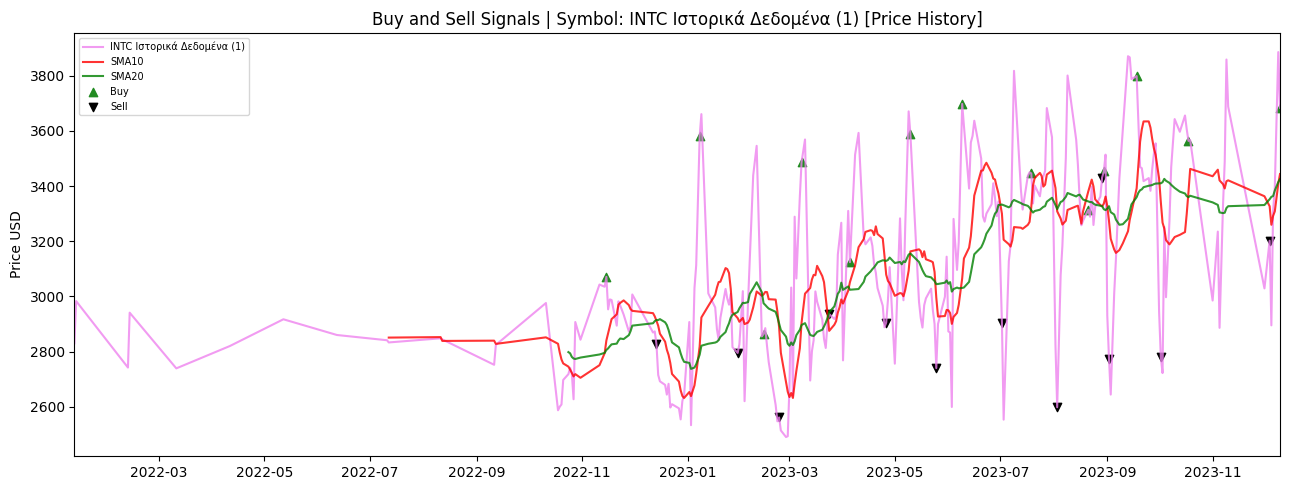

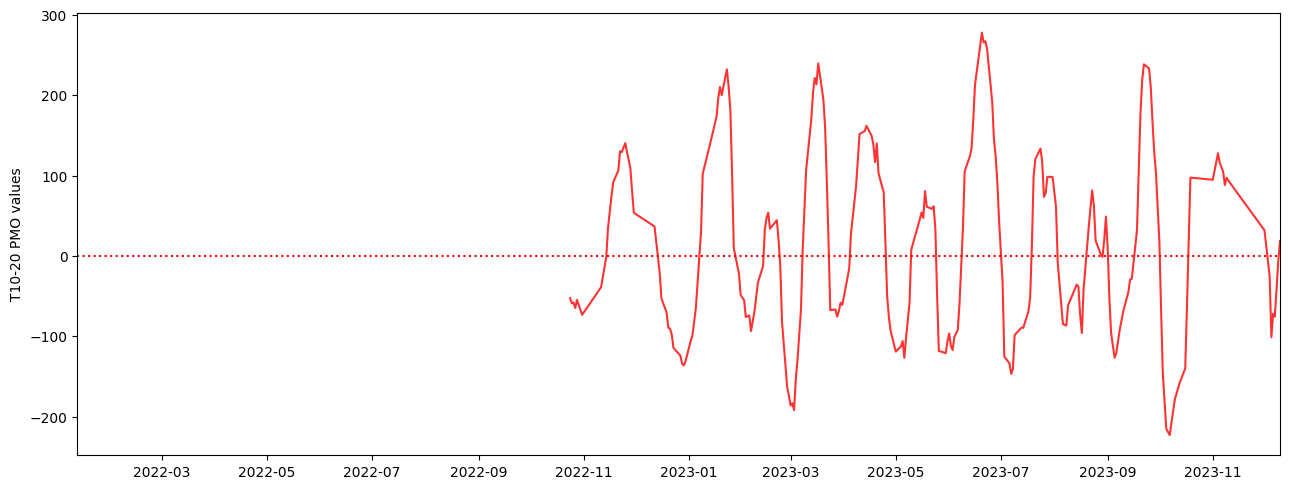

In [ ]:
#Βήμα 7 | PMO Plot Analysis (Buy and Sell Signals)
pmo_plot_total_signals(pmo_results,pmo_total_dates_report)